# Integrating cdes and maxpy

The point of this example file is to show how to add in maxpy to your files to add more automation to the design process. I'll be taking a very simply chip design of two capacitor pads and CPW meaninglessly placed on a chip. First, making the gds file using cdes, then simulating it in Maxwell to get the capacitance between the pads, ground, and the line.

Let's make the chip first.

In [20]:
# imports

import gdspy
import numpy as np

from cdes.CoplanarShapes import *
from cdes.CombinedShape import CombinedShape
from cdes.create_metallization import create_metallization
from cdes.write_gds import *

import os
import sys

import maxpy

In [21]:
# initial settings

PI = np.pi

name = 'maxpy_example'

global_settings = dict(unit=1.0e-6, precision=1.0e-9, chip_size=[2200, 1200], main_layer=5, trap_size=[3, 3], \
                        flux_trap_step=10, include_traps=False, xover_layer1=30, xover_layer2=31, \
                        add_alignment_marks=False,  combine_polygons=True, crop = [[170,100],[1050,1000]],subtract_outside_metallizations=True)

layer_settings = dict(mLayer=5, RR1=30, B1 = 31)

xover_settings = dict(density_per_micron=0.002, distance=30, size_30_x=12, size_30_y=12, size_31_x=12, 
                                   size_31_y=12, xover_width=12, xovers_in_arc=1)
    
    
coplanar_settings = dict(width=10, gap=6, no_traps=20, flux_traps=40, arcrad=50, xover_settings=xover_settings)

resonator_settings = dict(targetLength=5000, numturn=2, arcrad=70, hanging=True, 
                          straight_length=100,  xover_settings=xover_settings, 
                            coupling_length=350, with_spacer=True, width=10, gap=6, no_traps=20, flux_traps=40)

p = [0,0]

In [22]:
#defining CPW


line = CoplanarLine(coplanar_settings, path_list = [('y', 1200, True)], id=1)


# defining capacitor pads

s_paddle=dict(pad_x=104, pad_y=272, pad_gap=64, rounding=0, outside_gap=64, no_traps=20, flux_traps=40)
pads=CapacitorPads(s_paddle)

In [23]:
# placing element on chip

lineShape = CombinedShape()
lineShape.add(line)

caps = CombinedShape()
caps.add(pads)

global_settings['origin'] = 'bottom_left_corner'

cell = create_metallization([lineShape.place_on_chip(position = [300,0]), \
                             caps.place_on_chip(position=[420,570])], \
                            global_settings=global_settings, name=name)
write_single_split(cell)



We've now created the basic chip we had in mind, it looks like this

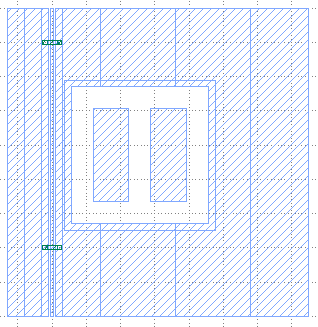

We want to see what all the capacitances are using Maxwell. We can do this using the maxpy package.

There are a couple quick steps you must do before simulating with maxpy. First, you should open the gds file and connect all the disconnected elements that are actually meant to be together and resave it, this will make maxwell happy. 

Now it looks like this
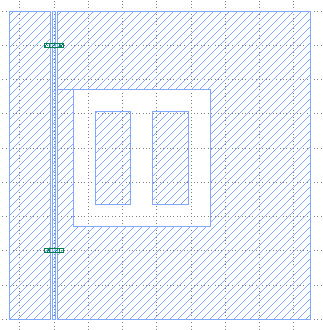

We also want to take note of the number of elements within each layer, for example here we have 5 in layer 5, 4 in layer 30, and 2 in layer 31. 

Now let's start the simulation in Maxwell using the maxpy package

In [28]:
# necessary parameters

folder_loc = "C:\\Users\\Erik Porter\\Desktop\\maxpy\\"  # change to where you cloned the repo

GDS_LOC = folder_loc + "maxpy_example.gds"
script = folder_loc + "example_script.py"
design = 'example_design'
project = 'example_project'


We need the location of the GDS file we just created and a location for the maxwell script to be written to. Design and Project names are just internal things for maxwell in case you have multiple designs or projects, create different instances of Maxwell() for each.

Then we can do the first steps, initializing the object and giving it the information we just specified.

In [29]:
mw = maxpy.Maxwell(script, project, design, GDS_LOC, clear=True)
mw.initialize()
mw.addLayers({5:5, 30:4, 31:2})
mw.importGDS()

Initialize just works on some of the basic housekeeping things necessary for writing the script. Here we put in the element number information we had taken note of, and then import the GDS file. The import step takes care of most of the steps you would consider when getting the simulation set up.

At this point, depending on the desgin, we made need to open the gds file up in Maxwell to determine how the import is done, so we can see the names of certain elements. We need to unite the ground planes through the cross overs, so we need to know which of the signals in layer 5 correspond to the ground plane. Once we do this, we see it was signal 3 and 5 within layer 5. So now we can unite these signals and begin assigning excitations.

In [30]:
mw.unite([mw.signals[5][2], mw.signals[5][4]] + mw.signals[30]+ mw.signals[31])  # unites all signals in layer 30, layer 31, and the ground plane from layer 5
mw.rename('Signal5_3', 'GND')  # renames groundplane, keeps name from first signal in unite arguement after uniting

mw.rename('Signal5_1', 'cap1')
mw.rename('Signal5_2', 'cap2')
mw.rename('Signal5_4', 'CPW')  # all this naming is not necessary, but makes it clearer sometimes


mw.voltage('0V', 'GND', 'ground')  # assigns a voltage to the signal GND, calling it ground, and setting it to 0V
excitations = ['ground']
# We need to assign a  voltage to every signal we want to take place in the capacitance matrix

for i in ['cap1', 'cap2', 'CPW']:
    mw.voltage('1V', i, i + '_volt')
    excitations.append(i + '_volt')
    
mw.problemRegion()  # defined the prob;lem region to run the simulation over

Now the model is completely setup, and we just need to set up the simulation and the run the analysis

In [31]:
setup = 'example_setup'
matrix = 'Matrix1'
result_loc = f'{folder_loc}{project}_{design}_results.txt'
OPEN = True  # if you want the script to auto open maxwel

mw.matrix(excitations, matrix)
mw.setup(setup, minPass=2, maxPass=20, error=2)
mw.analyze(setup, matrix,  result_loc)


# change to whereever you ANSYS maxwell download is
max_loc = "C:\ProgramData\Microsoft\Windows\Start Menu\Programs\ANSYS EM Suite 19.2\ANSYS Electronics Desktop 2018.2.lnk"  

if OPEN:
    os.startfile(max_loc)

Now we just need to go into the maxwell application and click, run script and select the file we just created. 

The run script file can be found in the automation tab and looks like
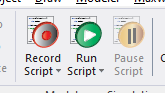

Once you run the script, the simulation will automatically start running and export the results from the written script.

Now that it is done running, we can parse the results using maxParse()

In [32]:
parser = maxpy.maxParse(result_loc)

That's all it takes, now we can access all the information from the simulation

In [47]:
print(f'The units for the matrix are "{parser.units}"')
print(f"Capacitance between the two pads is {np.abs(float(parser.capacitance['cap1_volt']['cap2_volt']))} {parser.units}")
print(f"Capacitance between pad 1 and ground is {np.abs(float(parser.capacitance['cap1_volt']['ground']))} {parser.units}")
      

The units for the matrix are "pF"
Capacitance between the two pads is 0.014406 pF
Capacitance between pad 1 and ground is 0.050399 pF


Some of the functionality requires having the model open so you can see what maxwell names the signals, but luckily it happens the same each time, so if you just open the file once, check the names, they will be the same for other instances. If you want to do some parameterization, you can create different instances of maxwell, just pass in the parameter clear=False when instantiating it so the code adds to the end of the script rather than overwriting it, that way it will to each one after the previous with only having to run one script.

One issue with running a lot of simulations is that you may require a slightly different gds file each time. This would require rerunning the cdes code and overwriting the gds file. This undoes the merge step we did to prepare the gds file. I'd like to be able to automate this, but for now, if that is the functionality you require, just import the gds file as is to maxwell, taking this into account with the number of elements in the model, and then unite them within maxwell using the maxpy.maxwell.unite() method.

## Final comments

My ultimate goal for this package is for it to be something that is actually useful to all of you. With that in mind, if there are features you'd like added, bugs, or poorly designed sections, please let me know and I'll do my best to try and improve it with your comments in mind. This kind of thing is not my specialty, so it definitely has room for improvement. Thanks for all the comments I've already received from you all.